In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [ ]:
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow.keras.preprocessing import image_dataset_from_directory

# for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Define file paths

! git clone https://github.com/chibykelaw/Hamoye_capstone_project_smote.git
train_path = 'Hamoye_capstone_project_smote/Data/train/'
val_path = 'Hamoye_capstone_project_smote/Data/val/'
test_path = 'Hamoye_capstone_project_smote/Data/test/'

Cloning into 'Hamoye_capstone_project_smote'...
remote: Enumerating objects: 10799, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 10799 (delta 7), reused 21 (delta 3), pack-reused 10768
Receiving objects: 100% (10799/10799), 360.89 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (10810/10810), done.


In [ ]:
# generate train, test and validation sets from directory

train_ds = image_dataset_from_directory(train_path, label_mode = 'categorical',
                                        image_size = (528, 528))
val_ds = image_dataset_from_directory(val_path, label_mode = 'categorical',
                                      image_size = (528, 528))
test_ds = image_dataset_from_directory(test_path, label_mode = 'categorical',
                                       shuffle= False, image_size = (528, 528))                                    

Found 7556 files belonging to 4 classes.
Found 2160 files belonging to 4 classes.
Found 1084 files belonging to 4 classes.


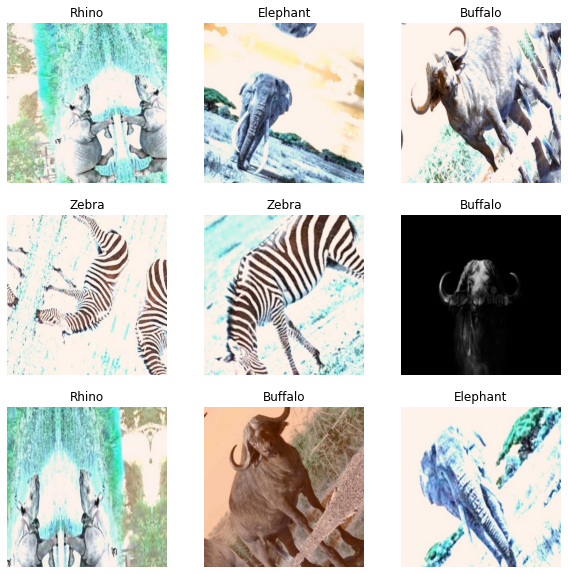

In [ ]:
# View dataset

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

(-0.5, 527.5, 527.5, -0.5)

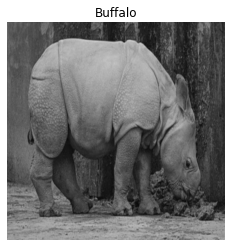

In [ ]:
for images, label in train_ds.take(1):
  first_image = images[0]

plt.imshow(first_image.numpy().astype("uint8"))
plt.title(class_names[np.argmax(label[i], axis=None, out=None)])
plt.axis('off')

In [ ]:
# make predictions using a pretrained model

from keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.preprocessing import image

x = image.img_to_array(first_image)
x = np.expand_dims(x, axis=0)

base_model = EfficientNetB6(weights='imagenet')
pred = base_model.predict(x)
print('Predicted:', decode_predictions(pred))

49152/35363 [=========================================] - 0s 0us/step
Predicted: [[('n02398521', 'hippopotamus', 0.7757862), ('n01704323', 'triceratops', 0.040475704), ('n02504013', 'Indian_elephant', 0.008777515), ('n02504458', 'African_elephant', 0.0072573023), ('n02454379', 'armadillo', 0.004746104)]]


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = EfficientNetB6(weights='imagenet', include_top=False,
                            input_shape=(528, 528,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

165249024/165234480 [==============================] - 5s 0us/step


In [12]:
# create callbacks fr training
my_callbacks = tf.keras.callbacks.ModelCheckpoint('weights.h5', save_best_only = True,
                                                  save_weights_only = True)

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_ds, 
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[my_callbacks])

Epoch 1/10
237/237 [==============================] - 1118s 5s/step - loss: 0.1490 - accuracy: 0.9708 - val_loss: 0.0328 - val_accuracy: 0.9954
Epoch 2/10
237/237 [==============================] - 1076s 5s/step - loss: 0.0316 - accuracy: 0.9934 - val_loss: 0.0198 - val_accuracy: 0.9958
Epoch 3/10
237/237 [==============================] - 1076s 5s/step - loss: 0.0205 - accuracy: 0.9951 - val_loss: 0.0158 - val_accuracy: 0.9958
Epoch 4/10
237/237 [==============================] - 1085s 5s/step - loss: 0.0148 - accuracy: 0.9974 - val_loss: 0.0136 - val_accuracy: 0.9954
Epoch 5/10
237/237 [==============================] - 1084s 5s/step - loss: 0.0121 - accuracy: 0.9972 - val_loss: 0.0122 - val_accuracy: 0.9958
Epoch 6/10
237/237 [==============================] - 1076s 5s/step - loss: 0.0108 - accuracy: 0.9979 - val_loss: 0.0120 - val_accuracy: 0.9958
Epoch 7/10
237/237 [==============================] - 1075s 5s/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.0112 - val_accuracy:

In [14]:
# save results
results = history.history

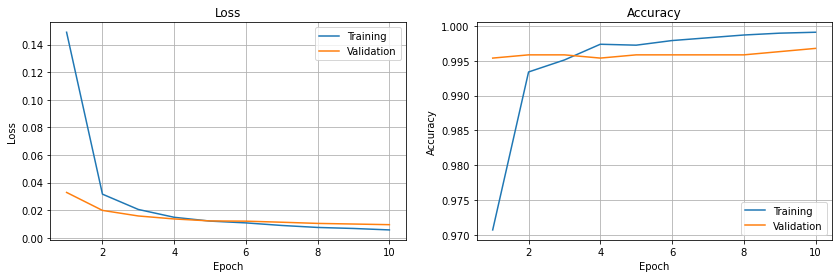

In [15]:
# plot results

n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
model.load_weights('weights.h5')

In [17]:
predictions = model.evaluate(test_ds)

34/34 [==============================] - 126s 4s/step - loss: 0.0052 - accuracy: 1.0000


In [18]:
# make predictions on the unseen data
predictions = model.predict(test_ds)
predictions

array([[9.9901712e-01, 7.2388117e-05, 7.9839164e-04, 1.1201100e-04],
       [9.9975055e-01, 5.4035871e-05, 1.5665633e-04, 3.8828337e-05],
       [9.9617213e-01, 2.1951846e-05, 3.7568777e-03, 4.9090737e-05],
       ...,
       [2.8896309e-06, 8.7399349e-05, 2.8214763e-06, 9.9990690e-01],
       [8.4766079e-06, 7.1584538e-05, 6.2333943e-06, 9.9991369e-01],
       [3.5810024e-07, 3.6848251e-06, 5.6924563e-07, 9.9999535e-01]],
      dtype=float32)

In [19]:
# save the index of the highest probability
predictions = predictions.argmax(axis=1)
predictions

array([0, 0, 0, ..., 3, 3, 3])

In [20]:
# get the actual values

test_images = list(test_ds.unbatch().as_numpy_iterator())
y_true = np.array([i[1] for i in test_images])
y_true = y_true.argmax(axis=1)
y_true

array([0, 0, 0, ..., 3, 3, 3])

In [21]:
# calculate f1_score
from sklearn.metrics import f1_score
f1_score(y_true,predictions,average='macro')

1.0

In [22]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,predictions)

array([[271,   0,   0,   0],
       [  0, 271,   0,   0],
       [  0,   0, 271,   0],
       [  0,   0,   0, 271]])

**This looks like a perfect model with perfect accuracy**

In [24]:
# Save the model as .pkl

import pickle
pickle.dump(model, open('EfficientNetB6_1.0.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://708bfdb6-fed8-4ca2-b3f7-7046c98ba932/assets
